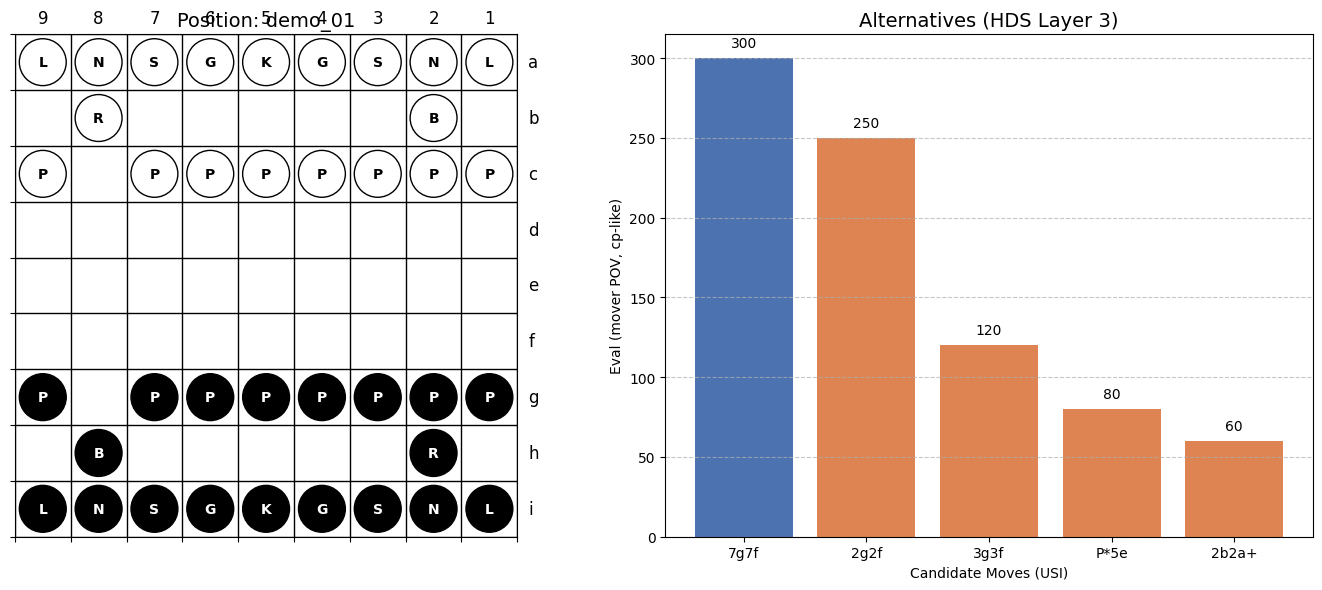


--- [TABLE] ---
 move  mover_eval  gap_to_best      risk_category  policy  pv_len move_type  hds_score                                                                                  eval_comment
 7g7f       300.0          0.0    low_risk_stable    0.45       3    normal   1.520000      最善級の安定手。 最善との差=0cp（最善比100.0%）。 形式=通常 / policy≈0.45 / PV長=3。 EVR≈[300.0, 317.2]（中心300.0）。
 2g2f       250.0         50.0    low_risk_stable    0.30       3    normal   1.188718      最善級の安定手。 最善との差=50cp（最善比83.3%）。 形式=通常 / policy≈0.30 / PV長=3。 EVR≈[233.0, 263.5]（中心250.0）。
 3g3f       120.0        180.0           balanced    0.15       2    normal   0.623407 実戦的だが見劣りが出る手。 最善との差=180cp（最善比40.0%）。 形式=通常 / policy≈0.15 / PV長=2。 EVR≈[58.0, 127.8]（中心120.0）。
 P*5e        80.0        220.0 high_risk_gambling    0.08       2      drop   0.551714    勝負手寄り（リスク高）。 最善との差=220cp（最善比26.7%）。 形式=打ち / policy≈0.08 / PV長=2。 EVR≈[-1.8, 90.0]（中心80.0）。
2b2a+        60.0        240.0 high_risk_gambling    0.05       2   promote   

In [1]:
# ============================================================
# Shogi Engine Decision Visualization (HDSフレーム・ブラッシュアップ版)
# - Objective → Axes → Alternatives → Risk(EVR) → Choice
# - Engine-agnostic: 「候補手 + eval(+ optional policy/pv)」を差し込むだけ
# - Deterministic: 乱数なし／安定ソート（moveでタイブレーク）
# - Fairness: 本デモは「重み推定」や「内部学習情報の逆算」は扱わない（ログ翻訳まで）
# ============================================================

from dataclasses import dataclass
from typing import Dict, List, Optional, Any, Tuple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


# -----------------------------
# 0) 設定（ここだけ触れば運用が変わる）
# -----------------------------

ENGINE_NAME = "YourEngine"
# gap(最善との差)でリスク分類（cp相当）
GAP_SMALL = 80
GAP_MEDIUM = 200

# evalの視点
# - "sente"      : +が先手（黒）有利
# - "gote"       : +が後手（白）有利
# - "side_to_move": +が手番側有利
EVAL_PERSPECTIVE = "sente"

# HDS: Axesの重み（エンジン順位を置き換えず、説明層の構造化に使う）
# ※Choiceは原則 eval（手番視点）最大で決める
AXIS_WEIGHTS = {
    "value": 1.00,       # eval（主目的）
    "stability": 0.35,   # gapの小ささ（安定）
    "confidence": 0.20,  # policy等（確信度っぽい）
    "complexity": 0.10,  # pvの長さ（読み筋の長さを“複雑さ”として参照）
    "tactical": 0.15,    # 打ち/成り等の“局面撹乱度”っぽい参照
}

# 表示する候補数
SHOW_TOP_K = 5


# -----------------------------
# 1) 型（Data Types）
# -----------------------------

@dataclass(frozen=True)
class CandidateMove:
    """
    USI:
      - 通常: "7g7f"（from-to）
      - 成り: "2b2a+"
      - 打ち: "P*5e"
    eval_cp:
      - cp相当（符号は EVAL_PERSPECTIVE に従う）
    """
    move: str
    eval_cp: Optional[int] = None
    policy: Optional[float] = None
    pv: Optional[str] = None
    desc: Optional[str] = None
    label: Optional[str] = None


@dataclass(frozen=True)
class PositionInput:
    position_id: str
    sfen: str
    side_to_move: str  # "b" or "w"（SFENの手番と合わせるのが安全）
    candidate_moves: List[CandidateMove]


@dataclass(frozen=True)
class EVR:
    base: float
    downside: float
    upside: float

    @property
    def low(self) -> float:
        return self.base - self.downside

    @property
    def high(self) -> float:
        return self.base + self.upside


@dataclass(frozen=True)
class HDSReport:
    position_id: str
    best_move: str
    table_df: pd.DataFrame
    hds_log: str
    executive_summary_ja: str


# -----------------------------
# 2) SFENユーティリティ（軽量）
# -----------------------------

# 将棋駒の簡易価値（“説明”用。精密評価ではない）
# 参考値：P=1, L=3, N=3, S=4, G=5, B=8, R=10, K=0
# 成駒：+P/+L/+N/+S は金相当(5)、馬(+B)=9、龍(+R)=11
PIECE_VALUE = {
    "P": 1, "L": 3, "N": 3, "S": 4, "G": 5, "B": 8, "R": 10, "K": 0,
    "+P": 5, "+L": 5, "+N": 5, "+S": 5, "+B": 9, "+R": 11,
}

def _split_sfen(sfen: str) -> Tuple[str, str, str, str]:
    parts = sfen.strip().split()
    # board turn hands move_number
    if len(parts) < 4:
        raise ValueError("SFENの形式が不正です（board turn hands move_number が必要）")
    return parts[0], parts[1], parts[2], parts[3]

def _parse_board(board_part: str) -> List[List[Optional[str]]]:
    """
    9x9 の盤を返す。要素は "P","p","+P","+p" のような文字列（promoteは '+'付き）。
    """
    rows = board_part.split("/")
    if len(rows) != 9:
        raise ValueError("SFEN盤面が9段ではありません")

    board = [[None for _ in range(9)] for _ in range(9)]
    for r_idx, row in enumerate(rows):
        c = 0
        i = 0
        while i < len(row):
            ch = row[i]
            if ch.isdigit():
                c += int(ch)
                i += 1
                continue
            if ch == "+":
                # promoted: next char is piece
                pc = row[i+1]
                board[r_idx][c] = "+" + pc
                c += 1
                i += 2
                continue
            # normal piece
            board[r_idx][c] = ch
            c += 1
            i += 1
        if c != 9:
            raise ValueError("SFEN盤面の段が9列に合いません")
    return board

def _parse_hands(hands_part: str) -> Dict[str, int]:
    """
    持ち駒：例 "2Rb3p" 等。'-' はなし。
    返り値はキーを "P","p","R","r" のように保持（大文字=先手、小文字=後手）
    """
    if hands_part == "-":
        return {}
    hands: Dict[str, int] = {}
    num = ""
    for ch in hands_part:
        if ch.isdigit():
            num += ch
        else:
            n = int(num) if num else 1
            hands[ch] = hands.get(ch, 0) + n
            num = ""
    return hands

def _material_balance_simple(sfen: str) -> Dict[str, int]:
    """
    盤上 + 持ち駒の簡易材評価を返す
    - sente_material, gote_material, diff(sente-gote)
    """
    board_part, turn, hands_part, _ = _split_sfen(sfen)
    board = _parse_board(board_part)
    hands = _parse_hands(hands_part)

    sente = 0
    gote = 0

    def add_piece(pc: str):
        nonlocal sente, gote
        # pc: "P","p","+P","+p"
        is_sente = pc.isupper()
        base = pc.upper()
        key = base if not base.startswith("+") else base  # "+P" etc
        v = PIECE_VALUE.get(key, 0)
        if is_sente:
            sente += v
        else:
            gote += v

    for r in range(9):
        for c in range(9):
            pc = board[r][c]
            if pc:
                add_piece(pc)

    for pc, n in hands.items():
        is_sente = pc.isupper()
        base = pc.upper()
        v = PIECE_VALUE.get(base, 0)
        if is_sente:
            sente += v * n
        else:
            gote += v * n

    return {"sente_material": sente, "gote_material": gote, "diff": sente - gote, "turn": turn}

def _find_king(board: List[List[Optional[str]]], sente: bool) -> Optional[Tuple[int,int]]:
    target = "K" if sente else "k"
    for r in range(9):
        for c in range(9):
            if board[r][c] == target:
                return (r, c)
    return None

def _king_safety_proxy(sfen: str) -> Dict[str, float]:
    """
    “玉周りの密度”を安全度として雑に見る（説明用）
    - king_ring_friends: 玉8近傍の味方駒数
    - king_ring_enemies: 玉8近傍の敵駒数
    """
    board_part, turn, _, _ = _split_sfen(sfen)
    bd = _parse_board(board_part)

    def ring_counts(sente: bool) -> Tuple[int,int]:
        kpos = _find_king(bd, sente)
        if not kpos:
            return (0, 0)
        kr, kc = kpos
        fr = 0
        en = 0
        for dr in (-1, 0, 1):
            for dc in (-1, 0, 1):
                if dr == 0 and dc == 0:
                    continue
                rr = kr + dr
                cc = kc + dc
                if rr < 0 or rr > 8 or cc < 0 or cc > 8:
                    continue
                pc = bd[rr][cc]
                if not pc:
                    continue
                if pc.isupper() == sente:
                    fr += 1
                else:
                    en += 1
        return fr, en

    sf, se = ring_counts(True)
    gf, ge = ring_counts(False)

    return {
        "sente_king_ring_friends": sf,
        "sente_king_ring_enemies": se,
        "gote_king_ring_friends": gf,
        "gote_king_ring_enemies": ge,
        "turn": turn,
    }


# -----------------------------
# 3) evalの視点変換（手番視点へ）
# -----------------------------

def eval_to_mover_pov(eval_cp: Optional[float], side_to_move: str) -> Optional[float]:
    """
    返り値: 「手番側にとって良いほど +」となる評価
    """
    if eval_cp is None:
        return None

    stm_is_sente = (side_to_move == "b")

    if EVAL_PERSPECTIVE == "sente":
        # + is good for sente
        return float(eval_cp) if stm_is_sente else -float(eval_cp)

    if EVAL_PERSPECTIVE == "gote":
        # + is good for gote
        return -float(eval_cp) if stm_is_sente else float(eval_cp)

    if EVAL_PERSPECTIVE == "side_to_move":
        # + is good for side-to-move already
        return float(eval_cp)

    raise ValueError("EVAL_PERSPECTIVE が不正です")


# -----------------------------
# 4) move のタイプ判定（USI）
# -----------------------------

def classify_move_usi(move: str) -> str:
    if "*" in move:
        return "drop"
    if move.endswith("+"):
        return "promote"
    return "normal"

def pv_length(pv: Optional[str]) -> int:
    if not pv:
        return 0
    # pvは "7g7f 3c3d ..." のような空白区切り想定
    return len([x for x in pv.strip().split() if x])


# -----------------------------
# 5) HDSコア：メトリクス/EVR/コメント生成
# -----------------------------

def risk_category_from_gap(gap: float) -> str:
    if gap < GAP_SMALL:
        return "low_risk_stable"
    if gap < GAP_MEDIUM:
        return "balanced"
    return "high_risk_gambling"

def estimate_evr(
    base_eval: float,
    gap_to_best: float,
    policy: float,
    move_type: str,
    pv_len: int
) -> EVR:
    """
    EVR（Expected Value Range）風にレンジを付与（説明用・決定的）
    - downside: gap大 / policy低 / tactical要素大
    - upside  : policy高 / tactical要素 / pv_len長め（読み筋が付いてる）を軽く参照
    """
    pol = float(policy) if policy is not None else 0.0
    tactical_bonus = 0.0
    if move_type == "drop":
        tactical_bonus = 20.0
    elif move_type == "promote":
        tactical_bonus = 15.0

    # downside: gapが大きいほど、確信度が低いほど増える
    downside = 0.30 * gap_to_best + 40.0 * max(0.0, 0.35 - pol) + 0.25 * tactical_bonus

    # upside: policyが高い/ tactical/ pvが長いほど少し増える
    upside = 25.0 * min(1.0, pol) + 0.20 * tactical_bonus + 2.0 * min(20, pv_len)

    # 数値は“cp相当”のレンジ感
    return EVR(
        base=float(round(base_eval, 2)),
        downside=float(round(downside, 2)),
        upside=float(round(upside, 2)),
    )

def build_comment_ja(row: pd.Series) -> str:
    gap = float(row["gap_to_best"])
    ratio = float(row["eval_ratio"]) * 100.0
    cat = row["risk_category"]
    mtype = row["move_type"]
    pol = float(row["policy"]) if not pd.isna(row["policy"]) else 0.0
    pvlen = int(row["pv_len"])

    head = {
        "low_risk_stable": "最善級の安定手。",
        "balanced": "実戦的だが見劣りが出る手。",
        "high_risk_gambling": "勝負手寄り（リスク高）。"
    }[cat]

    mtxt = {"normal":"通常","drop":"打ち","promote":"成り"}[mtype]
    evr = row["evr"]

    return (
        f"{head} 最善との差={int(gap)}cp（最善比{ratio:0.1f}%）。"
        f" 形式={mtxt} / policy≈{pol:0.2f} / PV長={pvlen}。"
        f" EVR≈[{evr.low:0.1f}, {evr.high:0.1f}]（中心{evr.base:0.1f}）。"
    )

def hds_axis_score(row: pd.Series, best_eval: float) -> float:
    """
    “説明”のためのHDSスコア（Choiceの根拠ではなく、Axesの寄与を見える化）
    """
    # value（0〜1）
    v = float(row["mover_eval"]) if not pd.isna(row["mover_eval"]) else 0.0
    denom = best_eval if abs(best_eval) > 1e-9 else 1.0
    value = v / denom

    # stability（gapが小さいほど良い）
    gap = float(row["gap_to_best"])
    stability = 1.0 / (1.0 + gap / 80.0)

    # confidence（policy）
    pol = float(row["policy"]) if not pd.isna(row["policy"]) else 0.0
    confidence = min(1.0, max(0.0, pol))

    # complexity（pv_len：長いほど複雑=スコアは下げる扱いにしても良いが、ここは参照だけ）
    pvlen = int(row["pv_len"])
    complexity = 1.0 / (1.0 + pvlen / 12.0)

    # tactical（打ち/成りを軽く加点）
    mtype = row["move_type"]
    tactical = 0.6 if mtype == "drop" else (0.4 if mtype == "promote" else 0.0)

    s = (
        AXIS_WEIGHTS["value"] * value +
        AXIS_WEIGHTS["stability"] * stability +
        AXIS_WEIGHTS["confidence"] * confidence +
        AXIS_WEIGHTS["complexity"] * complexity +
        AXIS_WEIGHTS["tactical"] * tactical
    )
    return float(round(s, 6))


# -----------------------------
# 6) 可視化（盤面＋評価バー）
# -----------------------------

def plot_shogi_board_simple(sfen: str, ax):
    board_part, turn, hands_part, move_no = _split_sfen(sfen)
    bd = _parse_board(board_part)

    ax.set_xlim(0, 9)
    ax.set_ylim(0, 9)
    ax.set_aspect("equal")
    ax.set_xticks(np.arange(0, 10, 1))
    ax.set_yticks(np.arange(0, 10, 1))
    ax.grid(True, color="black", linewidth=1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # 筋 9〜1
    for i in range(9):
        ax.text(i + 0.5, 9.2, str(9 - i), ha="center", fontsize=12)

    # 段 a〜i
    letters = "abcdefghi"
    for i in range(9):
        ax.text(9.2, 8.5 - i, letters[i], va="center", fontsize=12)

    # 駒描画（簡易：○＋文字、成りは小さく +）
    for r in range(9):
        for c in range(9):
            pc = bd[r][c]
            if not pc:
                continue

            promoted = pc.startswith("+")
            base = pc[1] if promoted else pc
            is_sente = base.isupper()

            x = c + 0.5
            y = (8 - r) + 0.5

            face = "black" if is_sente else "white"
            txtc = "white" if is_sente else "black"

            circle = patches.Circle((x, y), 0.42, facecolor=face, edgecolor="black")
            ax.add_patch(circle)

            ax.text(
                x, y, base.upper(),
                ha="center", va="center",
                color=txtc, fontweight="bold", fontsize=10
            )

            if promoted:
                ax.text(
                    x - 0.25, y + 0.25, "+",
                    ha="center", va="center",
                    color=txtc, fontweight="bold", fontsize=9
                )

    ax.set_title(f"SFEN turn={turn} hands={hands_part} move={move_no}", fontsize=12)


def visualize_decision(df: pd.DataFrame, position: PositionInput):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    plot_shogi_board_simple(position.sfen, ax1)
    ax1.set_title(f"Position: {position.position_id}", fontsize=14)

    # 評価バー（手番視点mover_evalで描く）
    x = df["move"].tolist()
    y = df["mover_eval"].astype(float).tolist()

    best_move = df.loc[df["mover_eval"].idxmax(), "move"]
    colors = ["#4c72b0" if mv == best_move else "#dd8452" for mv in x]

    bars = ax2.bar(x, y, color=colors)
    ax2.set_ylabel("Eval (mover POV, cp-like)")
    ax2.set_xlabel("Candidate Moves (USI)")
    ax2.set_title("Alternatives (HDS Layer 3)", fontsize=14)
    ax2.grid(axis="y", linestyle="--", alpha=0.7)

    for bar in bars:
        h = bar.get_height()
        ax2.text(
            bar.get_x() + bar.get_width() / 2.0,
            h + (5 if h >= 0 else -15),
            f"{int(h)}",
            ha="center",
            va="bottom" if h >= 0 else "top",
            fontsize=10
        )

    plt.tight_layout()
    plt.show()


# -----------------------------
# 7) HDSログ生成
# -----------------------------

def generate_hds_log(df: pd.DataFrame, position: PositionInput, context: Dict[str, Any]) -> str:
    best = df.loc[df["mover_eval"].idxmax()]
    lines: List[str] = []

    lines.append("=== HDS DECISION LAYER LOG (SHOGI) ===")
    lines.append(f"Engine: {ENGINE_NAME} | ID: {position.position_id}")
    lines.append(f"SideToMove: {position.side_to_move} | EvalPerspective: {EVAL_PERSPECTIVE}")
    lines.append("-" * 60)

    # Layer 1
    lines.append("[LAYER 1: OBJECTIVE]")
    lines.append(">> 主目的: 手番視点での評価値（勝ちやすさ）最大化。")
    lines.append(">> 副次: ギャップ最小化（安定）/ policy参照（確信度）/ PV参照（説明補助）。")
    lines.append(f">> 局面補助情報: 材差(diff sente-gote)={context['material']['diff']} / 玉周り密度(sente)={context['king']['sente_king_ring_friends']} 味方, {context['king']['sente_king_ring_enemies']} 敵")
    lines.append("")

    # Layer 2
    lines.append("[LAYER 2: EVALUATION AXES]")
    for k, w in AXIS_WEIGHTS.items():
        lines.append(f"* {k}: weight={w:.2f}")
    lines.append("")

    # Layer 3
    lines.append("[LAYER 3: ALTERNATIVES ANALYSIS]")
    for _, r in df.iterrows():
        lines.append(
            f">> {r['move']}: mover_eval={int(r['mover_eval'])} "
            f"| gap={int(r['gap_to_best'])} | risk={r['risk_category']} "
            f"| policy={float(r['policy']):0.2f} | pv_len={int(r['pv_len'])} | type={r['move_type']}"
        )
        lines.append(f"   comment: {r['eval_comment']}")
    lines.append("")

    # Layer 4
    lines.append("[LAYER 4: RISK (EVR) ASSESSMENT]")
    for _, r in df.iterrows():
        evr: EVR = r["evr"]
        lines.append(
            f">> {r['move']}: EVR≈[{evr.low:0.1f}, {evr.high:0.1f}]（中心{evr.base:0.1f}） / {r['risk_category']}"
        )
    lines.append("")

    # Layer 5
    lines.append("[LAYER 5: FINAL CHOICE]")
    lines.append(f">> 選択手: {best['move']}")
    lines.append(f">> 採用理由: mover_eval最大（主目的）かつ gap={int(best['gap_to_best'])} / risk={best['risk_category']}.")
    lines.append(">> 注記: 本デモは“エンジン出力ログの構造化翻訳”まで。内部重み推定の提示はしない（フェアネス）。")

    return "\n".join(lines)


def generate_executive_summary(df: pd.DataFrame, position: PositionInput) -> str:
    best = df.loc[df["mover_eval"].idxmax()]
    others = df[df["move"] != best["move"]].sort_values("mover_eval", ascending=False)

    lines: List[str] = []
    lines.append(f"局面ID={position.position_id}。推奨は **{best['move']}**。")
    lines.append(f"手番視点eval={int(best['mover_eval'])} / gap={int(best['gap_to_best'])} / {best['risk_category']}。")
    lines.append(best["eval_comment"])

    if len(others) > 0:
        lines.append("")
        lines.append("他候補（上位）:")
        for _, r in others.head(2).iterrows():
            lines.append(
                f"- {r['move']}: eval={int(r['mover_eval'])}, gap={int(r['gap_to_best'])}, {r['risk_category']} | {r['eval_comment']}"
            )
    return "\n".join(lines)


# -----------------------------
# 8) メイン：1局面をHDSで説明
# -----------------------------

def explain_position(position: PositionInput, top_k: int = SHOW_TOP_K, do_visualize: bool = True) -> HDSReport:
    # 局面コンテキスト（補助）
    mat = _material_balance_simple(position.sfen)
    king = _king_safety_proxy(position.sfen)
    context = {"material": mat, "king": king}

    rows = []
    for c in position.candidate_moves:
        mover_eval = eval_to_mover_pov(c.eval_cp, position.side_to_move) if c.eval_cp is not None else None
        pol = float(c.policy) if c.policy is not None else 0.0
        pvlen = pv_length(c.pv)
        mtype = classify_move_usi(c.move)
        rows.append({
            "move": c.move,
            "eval_cp_raw": c.eval_cp,
            "mover_eval": mover_eval,
            "policy": pol,
            "pv": c.pv or "",
            "pv_len": pvlen,
            "move_type": mtype,
            "desc": c.desc or "",
            "label": c.label or "",
        })

    df = pd.DataFrame(rows)

    if df["mover_eval"].isna().all():
        raise ValueError("mover_eval が全てNoneです（eval_cpを与えるか、EVAL_PERSPECTIVE/side_to_moveを確認）。")

    # best / gap / ratio
    best_eval = float(df["mover_eval"].max())
    df["gap_to_best"] = (best_eval - df["mover_eval"]).astype(float)
    denom = best_eval if abs(best_eval) > 1e-9 else 1.0
    df["eval_ratio"] = (df["mover_eval"] / denom).astype(float)

    # risk
    df["risk_category"] = df["gap_to_best"].apply(risk_category_from_gap)

    # EVR
    evrs = []
    for _, r in df.iterrows():
        evr = estimate_evr(
            base_eval=float(r["mover_eval"]),
            gap_to_best=float(r["gap_to_best"]),
            policy=float(r["policy"]),
            move_type=str(r["move_type"]),
            pv_len=int(r["pv_len"])
        )
        evrs.append(evr)
    df["evr"] = evrs

    # HDSスコア（説明用）
    df["hds_score"] = df.apply(lambda r: hds_axis_score(r, best_eval=best_eval), axis=1)

    # コメント
    df["eval_comment"] = df.apply(build_comment_ja, axis=1)

    # 安定ソート（決定性）
    df_sorted = df.sort_values(
        by=["mover_eval", "gap_to_best", "hds_score", "move"],
        ascending=[False, True, False, True],
        kind="mergesort"  # 安定ソート
    ).reset_index(drop=True)

    # 表示用に上位Kに絞る（ログ自体は上位Kで十分）
    df_view = df_sorted.head(top_k).copy()

    # ログ生成
    hds_log = generate_hds_log(df_view, position, context)
    summary = generate_executive_summary(df_view, position)

    if do_visualize:
        visualize_decision(df_view, position)

    best_move = str(df_view.loc[0, "move"])
    return HDSReport(
        position_id=position.position_id,
        best_move=best_move,
        table_df=df_view,
        hds_log=hds_log,
        executive_summary_ja=summary,
    )


# -----------------------------
# 9) デモ（ここを書き換えればそのままGitHub/Kaggleで使える）
# -----------------------------

sample_position = PositionInput(
    position_id="demo_01",
    sfen="lnsgkgsnl/1r5b1/p1ppppppp/9/9/9/P1PPPPPPP/1B5R1/LNSGKGSNL b - 1",
    side_to_move="b",
    candidate_moves=[
        CandidateMove(move="7g7f", eval_cp=300, policy=0.45, pv="7g7f 3c3d 2g2f", desc="中央から主導権を取る筋。"),
        CandidateMove(move="2g2f", eval_cp=250, policy=0.30, pv="2g2f 8c8d 2f2e", desc="飛車先を伸ばす。"),
        CandidateMove(move="3g3f", eval_cp=120, policy=0.15, pv="3g3f 4c4d", desc="角道を通しつつ様子見。"),
        # 例：打ち/成りも混ぜると説明が分かりやすい
        CandidateMove(move="P*5e", eval_cp=80, policy=0.08, pv="P*5e 5d5e", desc="打ちで局面を撹乱（例）。"),
        CandidateMove(move="2b2a+", eval_cp=60, policy=0.05, pv="2b2a+ 3a2a", desc="成りで価値を取りに行く（例）。"),
    ],
)

rep = explain_position(sample_position, top_k=SHOW_TOP_K, do_visualize=True)

print("\n--- [TABLE] ---")
display_cols = ["move","mover_eval","gap_to_best","risk_category","policy","pv_len","move_type","hds_score","eval_comment"]
print(rep.table_df[display_cols].to_string(index=False))

print("\n" + rep.hds_log)
print("\n=== EXECUTIVE SUMMARY (JA) ===")
print(rep.executive_summary_ja)

# 決定性チェック（3回完全一致）
logs = []
sums = []
for _ in range(3):
    r = explain_position(sample_position, top_k=SHOW_TOP_K, do_visualize=False)
    logs.append(r.hds_log)
    sums.append(r.executive_summary_ja)
assert logs[0] == logs[1] == logs[2], "HDS Logs are not deterministic!"
assert sums[0] == sums[1] == sums[2], "Summaries are not deterministic!"
print("\nOK: 3回とも完全一致（決定的動作）。")
